In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Load data
df = pd.read_excel("FULLSET(2).xls")
df.head()

,JK,Usia Saat Ukur,Berat,Tinggi,BB/U,ZS BB/U,TB/U,ZS TB/U,BB/TB,ZS BB/TB
0,L,35,14.6,98.7,Normal,0.19,Normal,0.78,Normal,-0.33
1,L,36,14.6,98.7,Normal,0.09,Normal,0.60,Normal,-0.33
2,L,37,14.7,98.7,Normal,0.05,Normal,0.42,Normal,-0.25
3,L,40,15.0,100.8,Normal,-0.06,Normal,0.46,Normal,-0.46
4,L,41,16.2,102.0,Normal,0.46,Normal,0.60,Normal,0.20


In [ ]:
#Validasi Data (Cek Missing Values dan Tipe Data)
missing_values = df.isnull().sum()
dtypes = df.dtypes

# Menampilkan jumlah data kosong per kolom
print("Jumlah Data Kosong (Missing Values) per Kolom:")
print(missing_values)

# Menampilkan tipe data per kolom
print("\nTipe Data (Data Types) per Kolom:")
print(dtypes)

Jumlah Data Kosong (Missing Values) per Kolom:
JK                0
Usia Saat Ukur    0
Berat             0
Tinggi            0
BB/U              0
ZS BB/U           0
TB/U              0
ZS TB/U           0
BB/TB             0
ZS BB/TB          0
dtype: int64

Tipe Data (Data Types) per Kolom:
JK                 object
Usia Saat Ukur      int64
Berat             float64
Tinggi            float64
BB/U               object
ZS BB/U           float64
TB/U               object
ZS TB/U           float64
BB/TB              object
ZS BB/TB          float64
dtype: object


In [ ]:
# Preprocessing & Pemilihan fitur X dan Y yang digunakan
df = df.dropna()
df['JK'] = df['JK'].map({'L': 1, 'P': 0})  # Encode jenis kelamin

# Encode label BB/U: Kurang=0, Normal=1, Lebih=2
df['JK'] = df['JK'].map({'L': 1, 'P': 0})
df['BB/U'] = df['BB/U'].map({"Kurang": 0, "Normal": 1, "Lebih": 2})
df['TB/U'] = df['TB/U'].map({"Pendek": 0, "Normal": 1, "Tinggi": 2})
df['BB/TB'] = df['BB/TB'].map({"Kurang": 0, "Normal": 1, "Lebih": 2})
features = ['JK', 'Usia Saat Ukur', 'Berat', 'Tinggi']
targets = ['BB/U']

df.head()

,JK,Usia Saat Ukur,Berat,Tinggi,BB/U,ZS BB/U,TB/U,ZS TB/U,BB/TB,ZS BB/TB
0,NaN,35,14.6,98.7,1,0.19,1,0.78,1,-0.33
1,NaN,36,14.6,98.7,1,0.09,1,0.60,1,-0.33
2,NaN,37,14.7,98.7,1,0.05,1,0.42,1,-0.25
3,NaN,40,15.0,100.8,1,-0.06,1,0.46,1,-0.46
4,NaN,41,16.2,102.0,1,0.46,1,0.60,1,0.20


In [ ]:
df['BB/U'].value_counts()

,count
BB/U,
1,2206
0,273
2,181


In [ ]:
print("\n📦 Penanganan Outlier pada Fitur Numerik")
numerical_features = ['Usia Saat Ukur', 'Berat', 'Tinggi']

for col in numerical_features:
    print(f"\nMemproses kolom: '{col}'")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"  Jumlah outlier terdeteksi: {len(outliers)}")
    median_val = df[col].median()
    df[col] = np.where(
        (df[col] < lower_bound) | (df[col] > upper_bound),
        median_val,
        df[col]
    )

    print(f"  Outlier di kolom '{col}' telah diganti dengan nilai Median ({median_val:.2f}).")


📦 Penanganan Outlier pada Fitur Numerik

Memproses kolom: 'Usia Saat Ukur'
  Jumlah outlier terdeteksi: 0
  Outlier di kolom 'Usia Saat Ukur' telah diganti dengan nilai Median (30.00).

Memproses kolom: 'Berat'
  Jumlah outlier terdeteksi: 59
  Outlier di kolom 'Berat' telah diganti dengan nilai Median (12.00).

Memproses kolom: 'Tinggi'
  Jumlah outlier terdeteksi: 39
  Outlier di kolom 'Tinggi' telah diganti dengan nilai Median (88.00).


In [ ]:
X = df[features]
y = df[targets]

print(len(X))
print(len(y))

2660
2660


In [ ]:
#Split Function
def get_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train_90, X_test_10, y_train_90, y_test_10 = get_data(X, y, 0.1)
X_train_80, X_test_20, y_train_80, y_test_20 = get_data(X, y, 0.2)
X_train_70, X_test_30, y_train_70, y_test_30 = get_data(X, y, 0.3)
X_train_60, X_test_40, y_train_60, y_test_40 = get_data(X, y, 0.4)

In [ ]:
# Pemodelan LightGBM & Fungsi evaluasi
def evaluate_model(X_train, X_test, y_train, y_test):
    model = lgb.LGBMClassifier( learning_rate=0.1,
    num_iterations=100,
    min_data_in_leaf=20,
    random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro'),
        'recall': recall_score(y_test, y_pred, average='macro'),
        'f1': f1_score(y_test, y_pred, average='macro'),
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'y_pred': y_pred,
        'y_test': y_test
    }

learning_rate = 0.1
Nilai ini dipilih karena merupakan titik awal yang umum dan seimbang antara kecepatan pelatihan dan akurasi. Nilai ini tidak terlalu besar hingga menyebabkan overfitting, dan tidak terlalu kecil hingga pelatihan menjadi lambat. Pada eksperimen, 0.1 memberikan hasil terbaik secara efisien.

num_iterations = 100
Menentukan jumlah maksimum pohon yang dibangun. Dikombinasikan dengan learning_rate 0.1, nilai ini cukup untuk mencapai konvergensi tanpa overfitting atau underfitting.

min_data_in_leaf = 20
Mengatur jumlah minimum data dalam setiap leaf pohon. Nilai ini membantu mencegah overfitting dengan memastikan bahwa setiap split pohon memiliki cukup representasi data, menjaga kestabilan model.

random_state = 42
Digunakan agar pembagian data dan proses pelatihan berjalan konsisten setiap kali dijalankan ulang. Memastikan hasil model reproducible dan evaluasi tetap objektif.

In [ ]:
# Menjalankan Evaluasi untuk semua Ratio
result_90 = evaluate_model(X_train_90, X_test_10, y_train_90, y_test_10)
result_80 = evaluate_model(X_train_80, X_test_20, y_train_80, y_test_20)
result_70 = evaluate_model(X_train_70, X_test_30, y_train_70, y_test_30)
result_60 = evaluate_model(X_train_60, X_test_40, y_train_60, y_test_40)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 2394, number of used features: 3
[LightGBM] [Info] Start training from score -2.295924
[LightGBM] [Info] Start training from score -0.185334
[LightGBM] [Info] Start training from score -2.680854
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_


🔹 Rasio Train:Test = 90:10
  Accuracy : 0.95
  Precision: 0.95
  Recall   : 0.84
  F1-Score : 0.89


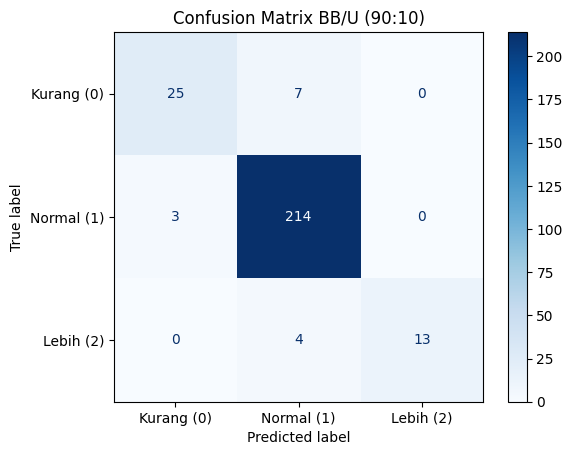


🔹 Rasio Train:Test = 80:20
  Accuracy : 0.95
  Precision: 0.93
  Recall   : 0.84
  F1-Score : 0.88


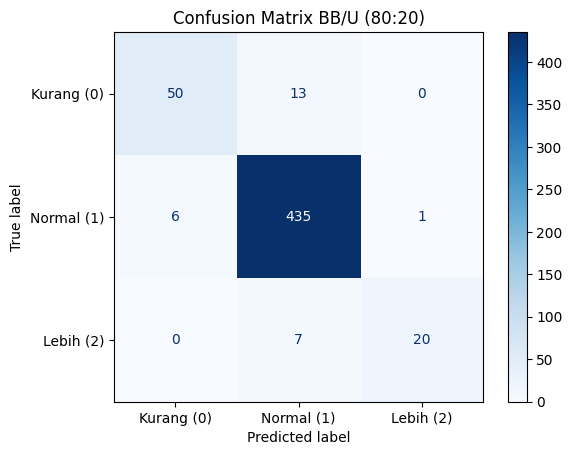


🔹 Rasio Train:Test = 70:30
  Accuracy : 0.96
  Precision: 0.94
  Recall   : 0.88
  F1-Score : 0.91


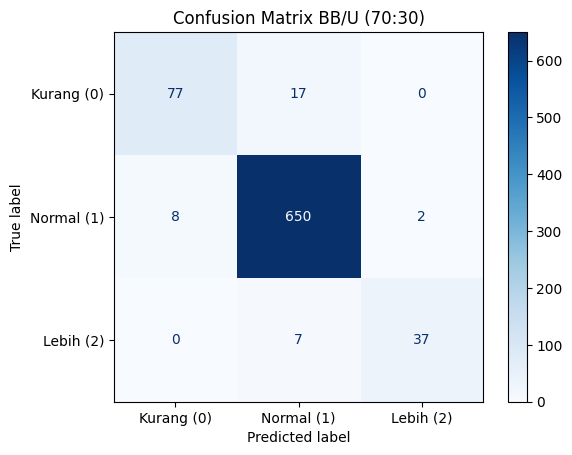


🔹 Rasio Train:Test = 60:40
  Accuracy : 0.94
  Precision: 0.90
  Recall   : 0.85
  F1-Score : 0.87


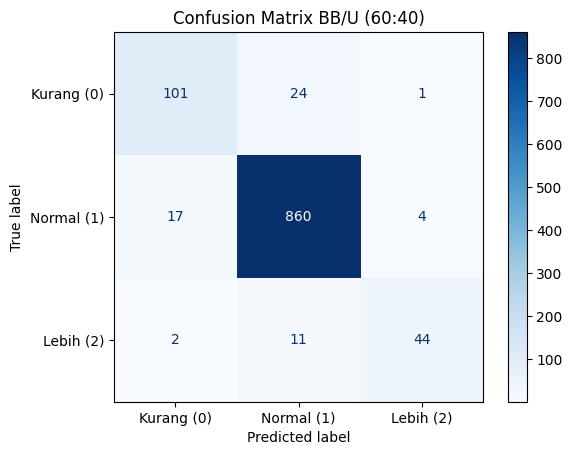

In [ ]:
# Visualisasi Confusion Matrix
result_arr = [result_90, result_80, result_70, result_60]
train_test_ratios = [(0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
labels = [0, 1, 2]
label_names = ["Kurang (0)", "Normal (1)", "Lebih (2)"]

for result, (train_size, test_size) in zip(result_arr, train_test_ratios):
    print(f"\n🔹 Rasio Train:Test = {int(train_size*100)}:{int(test_size*100)}")
    print(f"  Accuracy : {result['accuracy']:.2f}")
    print(f"  Precision: {result['precision']:.2f}")
    print(f"  Recall   : {result['recall']:.2f}")
    print(f"  F1-Score : {result['f1']:.2f}")

    y_test = result['y_test']
    y_pred = result['y_pred']

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix BB/U ({int(train_size*100)}:{int(test_size*100)})')
    plt.show()


📊 Analisis Feature Importance dari Model LightGBM
Ranking Fitur Berdasarkan Kepentingannya:
          Feature  Importance
2           Berat        3431
1  Usia Saat Ukur        2840
3          Tinggi        2727
0              JK           0


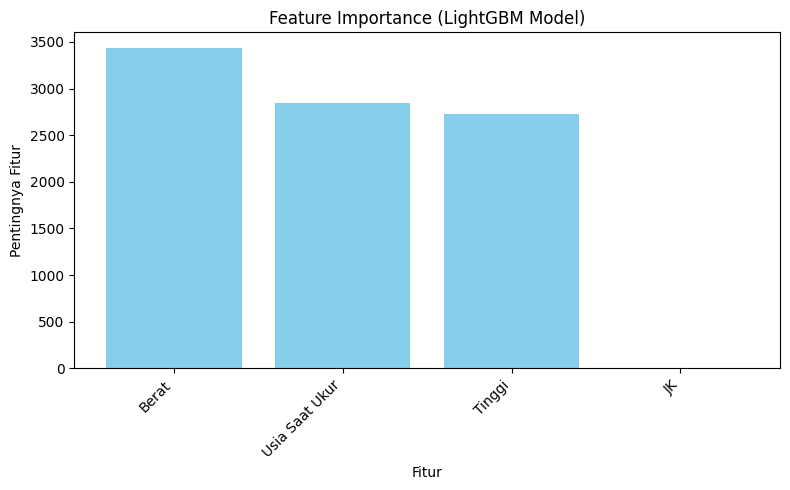

In [ ]:
print("\n📊 Analisis Feature Importance dari Model LightGBM")
model_to_analyze = result_80['model']
feature_importances = model_to_analyze.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Ranking Fitur Berdasarkan Kepentingannya:")
print(importance_df)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance (LightGBM Model)')
plt.xlabel('Fitur')
plt.ylabel('Pentingnya Fitur')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

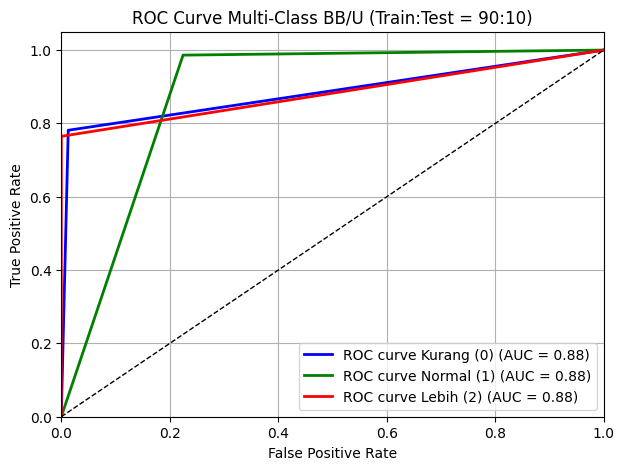

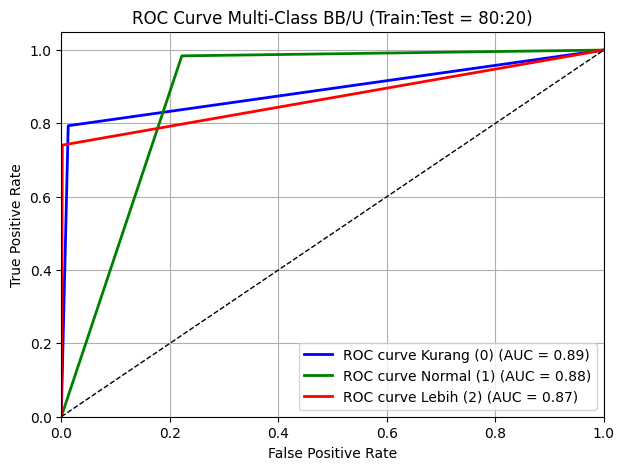

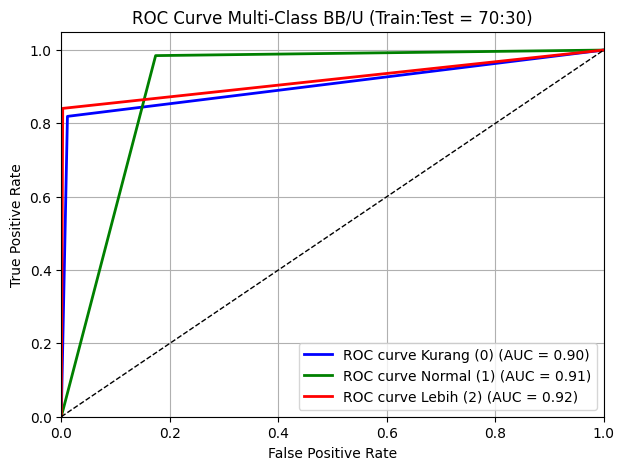

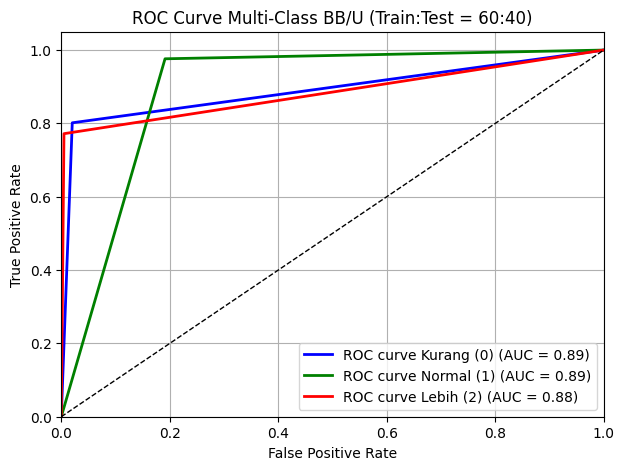

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Daftar hasil prediksi
result_arr = [result_90, result_80, result_70, result_60]
train_test_ratios = [(0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
labels = [0, 1, 2]
label_names = ["Kurang (0)", "Normal (1)", "Lebih (2)"]
colors = ['blue', 'green', 'red']

for result, (train_size, test_size) in zip(result_arr, train_test_ratios):
    y_test = result['y_test']
    y_pred = result['y_pred']

    # Binarisasi label
    y_test_bin = label_binarize(y_test, classes=labels)
    y_pred_bin = label_binarize(y_pred, classes=labels)

    # Inisialisasi figure
    plt.figure(figsize=(7, 5))

    for i, label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                 label=f'ROC curve {label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Multi-Class BB/U (Train:Test = {int(train_size*100)}:{int(test_size*100)})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [ ]:
def get_table(result_90, result_80, result_70, result_60):
    data = {
        'Train:Test Ratio': ['90:10', '80:20', '70:30', '60:40'],
        'Accuracy': [result_90['accuracy'], result_80['accuracy'], result_70['accuracy'], result_60['accuracy']],
        'Precision': [result_90['precision'], result_80['precision'], result_70['precision'], result_60['precision']],
        'Recall': [result_90['recall'], result_80['recall'], result_70['recall'], result_60['recall']],
        'F1-Score': [result_90['f1'], result_80['f1'], result_70['f1'], result_60['f1']]
    }
    df = pd.DataFrame(data)
    return df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

eval_df = get_table(result_90, result_80, result_70, result_60)
print(eval_df)

  Train:Test Ratio  Accuracy  Precision    Recall  F1-Score
0            70:30  0.957393   0.939664  0.881636  0.908805
1            80:20  0.949248   0.933761  0.839518  0.881190
2            90:10  0.947368   0.947989  0.844044  0.889442
3            60:40  0.944549   0.900173  0.849894  0.873265


In [ ]:
eval_df = get_table(result_90, result_80, result_70, result_60)
eval_df

,Train:Test Ratio,Accuracy,Precision,Recall,F1-Score
0,70:30,0.957393,0.939664,0.881636,0.908805
1,80:20,0.949248,0.933761,0.839518,0.881190
2,90:10,0.947368,0.947989,0.844044,0.889442
3,60:40,0.944549,0.900173,0.849894,0.873265


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import numpy as np

# Fungsi untuk evaluasi model dengan k-fold tertentu
def cross_validate_model(X, y, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    print(f"\n📘 Evaluasi dengan {n_splits}-Fold Cross Validation")

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgb.LGBMClassifier(
            learning_rate=0.1,
            n_estimators=100,           # perbaikan dari num_iterations
            min_data_in_leaf=20,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluasi dan simpan skor
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        accuracy_list.append(acc)
        precision_list.append(prec)
        recall_list.append(rec)
        f1_list.append(f1)

        print(f"\n🔸 Fold {fold + 1}")
        print(f"  Accuracy : {acc:.2f}")
        print(f"  Precision: {prec:.2f}")
        print(f"  Recall   : {rec:.2f}")
        print(f"  F1-Score : {f1:.2f}")

    # Rata-rata skor untuk semua fold
    print(f"\n📊 Rata-Rata Skor {n_splits}-Fold:")
    print(f"  Accuracy : {np.mean(accuracy_list):.2f}")
    print(f"  Precision: {np.mean(precision_list):.2f}")
    print(f"  Recall   : {np.mean(recall_list):.2f}")
    print(f"  F1-Score : {np.mean(f1_list):.2f}")

# Jalankan untuk 5, 7, dan 10 fold
for k in [5, 7, 10]:
    cross_validate_model(X, y, n_splits=k)


📘 Evaluasi dengan 5-Fold Cross Validation
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 2128, number of used features: 3
[LightGBM] [Info] Start training from score -2.273866
[LightGBM] [Info] Start training from score -0.187599
[LightGBM] [Info] Start training from score -2.686204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data

Dilakukan evaluasi performa model LightGBM menggunakan Stratified K-Fold Cross Validation dengan jumlah fold: 5, 7, dan 10, guna memastikan kestabilan dan keakuratan model pada berbagai pembagian data.

Hasil Evaluasi 5-Fold
- **Accuracy rata-rata**: 0.96
- **Precision**: 0.92
- **Recall**: 0.89
- **F1-Score**: 0.90

Hasil stabil dan cukup tinggi, cocok untuk klasifikasi BB/U.


Hasil Evaluasi 7-Fold
- **Accuracy rata-rata**: 0.96
- **Precision**: 0.94
- **Recall**: 0.88
- **F1-Score**: 0.91

Precision lebih tinggi, cocok untuk deteksi yang lebih akurat per kelas.


Hasil Evaluasi 10-Fold
- **Accuracy rata-rata**: 0.96
- **Precision**: 0.93
- **Recall**: 0.90
- **F1-Score**: 0.91

Konsisten terbaik secara keseluruhan. Model memiliki keseimbangan precision dan recall.


Evaluasi dengan K-Fold menunjukkan bahwa model LightGBM mampu mengklasifikasikan status gizi balita secara konsisten dan akurat, bahkan saat diuji dalam berbagai pembagian data. Cross validation ini juga membuktikan bahwa pemilihan parameter model sudah cukup optimal.

Meskipun cross validation seperti Stratified K-Fold memberikan evaluasi model yang lebih menyeluruh, dalam penelitian ini fokus diarahkan pada perbandingan performa model berdasarkan rasio pembagian data train dan test (60:40, 70:30, 80:20, 90:10). Pendekatan ini lebih sesuai untuk konteks implementasi riil, di mana model akan dilatih dan diuji sekali dengan data aktual yang representatif. Selain itu, tujuan utama penelitian adalah membangun dan mengintegrasikan model prediksi ke aplikasi Streamlit, sehingga efisiensi waktu pelatihan dan kesederhanaan proses menjadi prioritas.


Contoh Hasil Prediksi Data Uji (80:20):
      JK  Usia Saat Ukur  Berat  Tinggi  Actual  Predicted
1968 NaN             7.0    9.1    72.0       1          1
124  NaN            54.0   16.9   105.0       1          1
1127 NaN            16.0    9.5    76.2       1          1
1615 NaN             3.0    6.2    62.0       1          1
1359 NaN            28.0   16.3    90.0       2          2
650  NaN            23.0    8.7    79.8       0          0
1706 NaN            22.0    9.6    85.0       1          1
2019 NaN             6.0    6.8    67.4       1          1
173  NaN            48.0   12.0   106.2       2          2
461  NaN            32.0   10.7    88.5       0          0

Distribusi Status Gizi Aktual:
BB/U
Normal    442
Kurang     63
Lebih      27
Name: count, dtype: int64

Distribusi Prediksi Status Gizi:
Normal    455
Kurang     56
Lebih      21
Name: count, dtype: int64


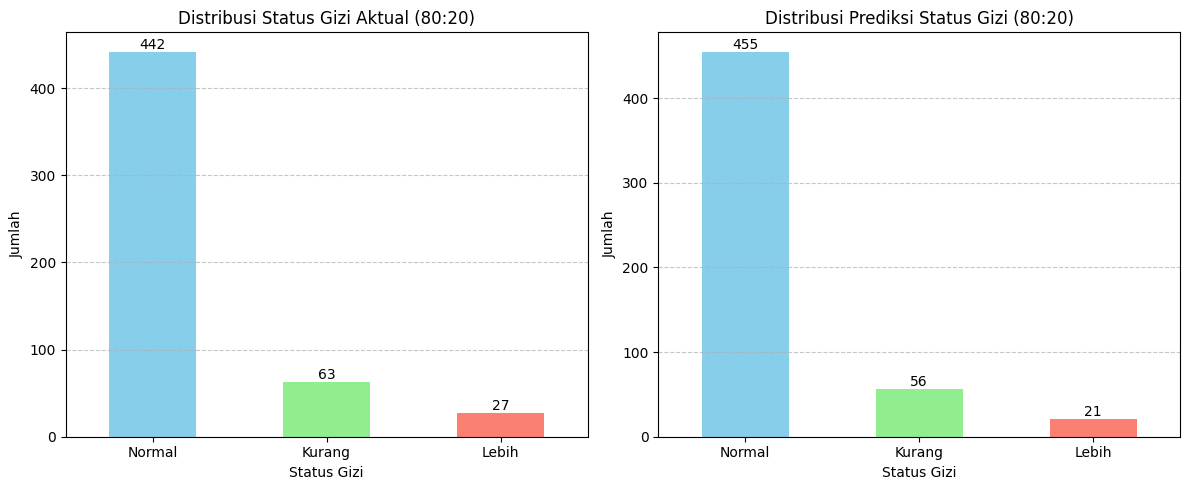

In [ ]:
# HASIL PREDIKSI AKTUAL (80:20)
print("\nContoh Hasil Prediksi Data Uji (80:20):")
# Access the result for the 80:20 split directly
selected = result_80

pred_df = X.loc[selected['y_test'].index].copy()
pred_df['Actual'] = selected['y_test']
pred_df['Predicted'] = selected['y_pred']
print(pred_df.head(10))

# INTERPRETASI NARATIF
status_map = {0: 'Kurang', 1: 'Normal', 2: 'Lebih'}
# Ensure y_test is a Series or flatten if it's a DataFrame column
count_actual = selected['y_test'].squeeze().map(status_map).value_counts()
count_pred = pd.Series(selected['y_pred']).map(status_map).value_counts()
print("\nDistribusi Status Gizi Aktual:")
print(count_actual)
print("\nDistribusi Prediksi Status Gizi:")
print(count_pred)

# Visualisasi Distribusi Aktual vs. Prediksi
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) # Membuat 2 subplot berdampingan

# Chart untuk Distribusi Aktual
count_actual.plot(kind='bar', ax=ax[0], color=['skyblue', 'lightgreen', 'salmon'])
ax[0].set_title('Distribusi Status Gizi Aktual (80:20)')
ax[0].set_xlabel('Status Gizi')
ax[0].set_ylabel('Jumlah')
ax[0].tick_params(axis='x', rotation=0) # Mengatur rotasi label sumbu x
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar chart aktual
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Chart untuk Distribusi Prediksi
count_pred.plot(kind='bar', ax=ax[1], color=['skyblue', 'lightgreen', 'salmon'])
ax[1].set_title('Distribusi Prediksi Status Gizi (80:20)')
ax[1].set_xlabel('Status Gizi')
ax[1].set_ylabel('Jumlah')
ax[1].tick_params(axis='x', rotation=0) # Mengatur rotasi label sumbu x
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar chart prediksi
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout() # Menyesuaikan layout agar tidak tumpang tindih
plt.show()

In [ ]:
import pickle

# Misal ini hasil dari training
result = result_80['model']

# Simpan ke file
with open('lgbm_terlatih_80.pkl', 'wb') as f:
    pickle.dump(result, f)